# First try - coupling between two oscillators

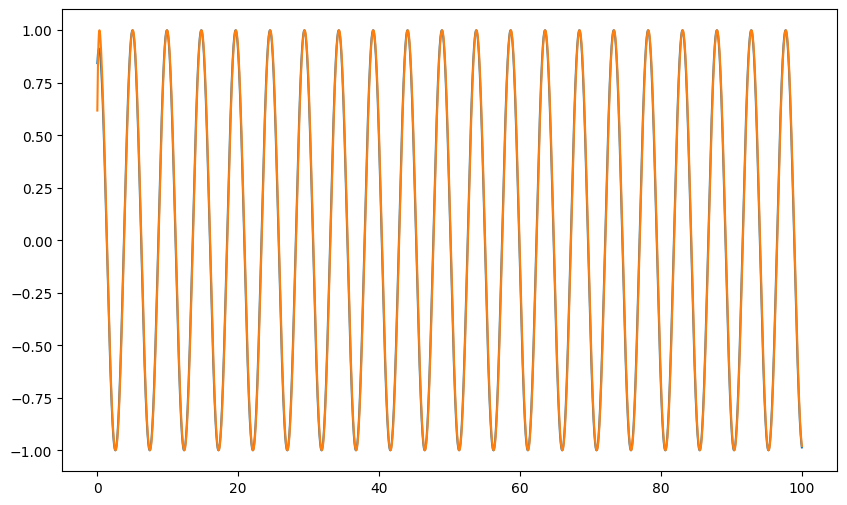

In [109]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def kuramoto_oscillators(theta, t, omega, K, N):
    dtheta_dt = omega - (K/N) * np.sum(np.sin(np.subtract.outer(theta, theta)), axis=1)
    return dtheta_dt

N = 2  # Number of oscillators
K = 5  # Increased coupling strength to make the coupling effect more visible
T = 100.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


theta0 = np.random.uniform(0, 2*np.pi, N) #initial phases
omega = np.ones(N)+np.random.uniform(0,0.5,N) #frequencies

thetas = odeint(kuramoto_oscillators, theta0, times, args=(omega, K, N))

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, np.sin(thetas[:, i]), label=f'Oscillator {i+1}')
plt.show()

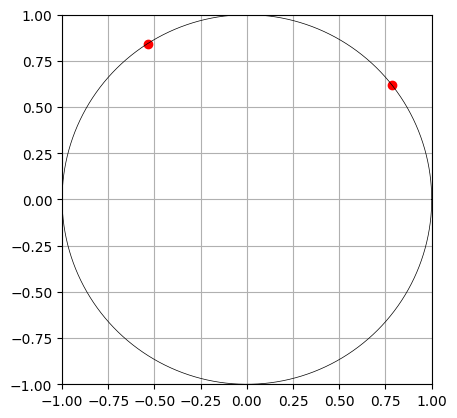

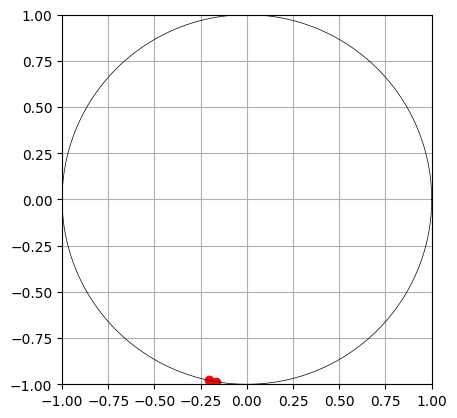

In [110]:
phi_circ = np.linspace(0,2*np.pi,2000)



figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[0,i]), np.sin(thetas[0,i]), c="red")
    
    
plt.show()

figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[-1,i]), np.sin(thetas[-1,i]), c="red")
    
plt.show()

# Multiple oscillators - coupling with randomly selected 4 neighbors

/home/mniszek/anaconda3/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.1334556651015D+00   r2 =  0.6392656993479D-07


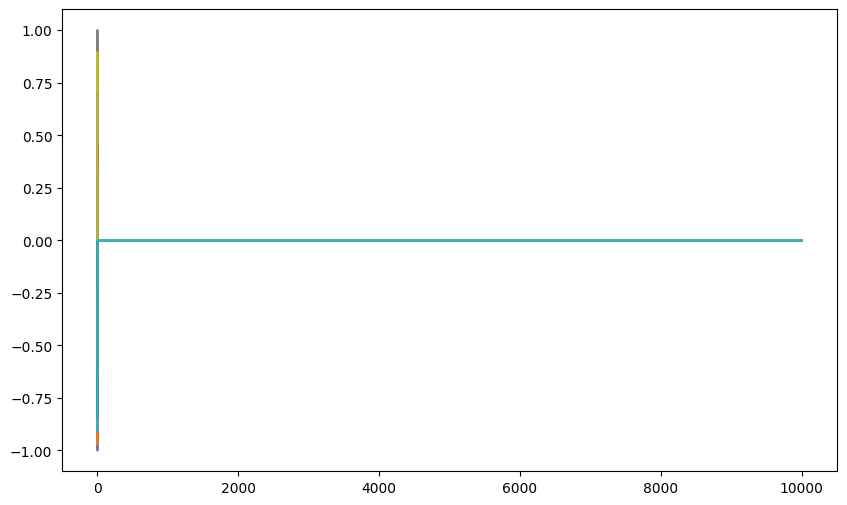

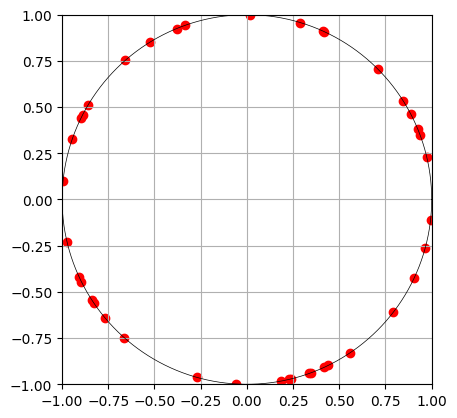

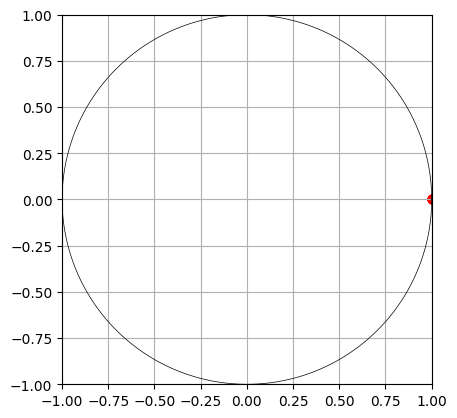

In [135]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def kuramoto_oscillators(theta, t, omega, K, N):
    neighboring_phases = np.random.choice(
        np.subtract.outer(thetas[0,:], thetas[0,:]).flatten()
        , 4, replace=False)
        
    dtheta_dt = omega - (K/N) * np.sum(np.sin(neighboring_phases), axis=0)
    return dtheta_dt

N = 40  # Number of oscillators
K = 5  # Increased coupling strength to make the coupling effect more visible
T = 10000.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


theta0 = np.random.uniform(0, 2*np.pi, N) #initial phases
omega = np.ones(N)+np.random.uniform(0,0.3,N) #frequencies

thetas = odeint(kuramoto_oscillators, theta0, times, args=(omega, K, N))

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, np.sin(thetas[:, i]), label=f'Oscillator {i+1}')
plt.show()

phi_circ = np.linspace(0,2*np.pi,2000)



figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[0,i]), np.sin(thetas[0,i]), c="red")
    
    
plt.show()

figure, axes = plt.subplots()
axes.set_aspect( 1 )
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
plt.grid()
plt.plot(np.cos(phi_circ),np.sin(phi_circ),c="black",linewidth=0.5)
for i in range(N):
    plt.scatter(np.cos(thetas[-1,i]), np.sin(thetas[-1,i]), c="red")
    
plt.show()

# Using networkx package for establishing connections
*Of course it can be done easily with plain python or numpy, but having specialized library is most often better and more legible choice*

- in the future, optimally, pytorch methods and objects should be used, but that will do after introductory models will prove to be useful and trainable

Definitions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import odeint
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import colorsys

def graph_weighted_plot(graph):
    """
    draw graph with edge weights and frequency values
    returns nothing
    """
    pos = dict((n, n) for n in graph.nodes())
    esmall = [(u, v) for (u, v, d) in graph.edges(data=True)]

    #nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    #edges
    nx.draw_networkx_edges(
        graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    #edge labels
    edge_labels = nx.get_edge_attributes(graph, "weight")
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)

    #node labels
    node_labels = {node: graph.nodes[node]['frequency'] for node in graph.nodes}
    nx.draw_networkx_labels(graph, pos, labels=node_labels, font_size=8, font_family="sans-serif")
    return

def adjust_values_to_range(matrix, lower_bound, upper_bound):
    """
    Adjust the values in the matrix to ensure they fall within the specified range.
    The lowest value in the matrix will be set to the lower_bound.
    """
    # Calculate the shift needed to set the lowest value to the lower_bound
    shift = lower_bound - np.min(matrix)
    matrix += shift
    
    # Ensure all values fall within the lower_bound to upper_bound range
    range_width = upper_bound - lower_bound
    matrix = (matrix - lower_bound) % range_width + lower_bound
    return matrix

def graph_pixel_plot(graph, g_len, g_wid):
    """
    Draw node values for square lattice graph with values ranging from -π to 0 in blue and 0 to π in orange.
    returns plot (pyplot figure object)

    g_len - maximal graph length
    g_wid - maximal graph width
    """
    plot_matrix = np.zeros([g_len, g_wid])
    points = graph.nodes
    for i in points:
        plot_matrix[i[0]][i[1]] = points[tuple(i)]["phase"]

    plot_matrix = adjust_values_to_range(plot_matrix, -np.pi, np.pi)
    norm = mcolors.TwoSlopeNorm(vmin=-np.pi, vcenter=0, vmax=np.pi)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("Pixel plot of network")

    img = ax.imshow(plot_matrix, cmap='coolwarm', norm=norm, interpolation='nearest')

    cbar = plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label='Phase Value')
    cbar.set_ticks([-np.pi, 0, np.pi])
    cbar.set_ticklabels([r'$-\pi$', r'0', r'$\pi$'])

    return fig, ax

def draw_phase_correlation(graph, rotate=False):
    """
    Draw a scatter plot with phase values of nodes on a unit circle.
    returns pyplot (figure, axis) tuple

    if rotate==True plot will be rotated so that "center of mass" of phases always points upwards
    """
    phase_array = []

    for node in graph.nodes():
        phase_array.append(graph.nodes[node]["phase"])
    x = np.cos(phase_array)
    y = np.sin(phase_array)


    #calcularting "COM"
    center_of_mass = np.array([np.sum(x),np.sum(y)])/len(phase_array)

    rotation_matrix=np.array([[1,0],[0,1]])
    if rotate:
        # Calculate the angle to rotate
        angle_to_com = np.arctan2(center_of_mass[1], center_of_mass[0])
        angle_to_rotate = -angle_to_com + np.pi/2
        rotation_matrix = np.array([[np.cos(angle_to_rotate), -np.sin(angle_to_rotate)], 
                                    [np.sin(angle_to_rotate), np.cos(angle_to_rotate)]])
        
    # Rotate all points
    for i in range(len(x)):
        [x[i], y[i]] = np.dot(rotation_matrix, np.array([x[i], y[i]]))
    
    # Recalculate COM after rotation
    center_of_mass = np.array([np.sum(x),np.sum(y)])/len(phase_array)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    ax.set_title(r"Phase Plot for All Nodes ($30^\circ$)")
    ax.scatter(x, y, c="r")


    plt.scatter(*center_of_mass,c="blue")
    plt.plot([0, center_of_mass[0]], [0, center_of_mass[1]], '-', linewidth=0.8, c="b")

    #plotting lines and circumference
    phi_circ = np.linspace(0, 2*np.pi, 2000)
    ax.plot(np.cos(phi_circ), np.sin(phi_circ), c="black", linewidth=0.5)
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])   
    angle_diff_deg = 30
    for angle in np.linspace(0, 2*np.pi, 12, endpoint=False):
        ax.plot([0, np.cos(angle)], [0, np.sin(angle)], 'k--', linewidth=0.5)
    
    return fig, ax

def add_neighboring_nodes(graph, lenx, leny):
    """
    add square lattice of nearest neighbor connected nodes
    lenx - integer length of graph
    leny - integer width of graph
    """
    points = [(x, y) for x in range(lenx) for y in range(leny)]
    for point in points:
        graph.add_node(point)
        x, y = point
        
        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        for ix, iy in neighbors:
            if (ix, iy) in points:
                graph.add_edge(point, (ix, iy))
    return

nx.Graph.add_neighboring_nodes = add_neighboring_nodes


def kuramoto_oscillators(theta, t, omega, K, N):
    dtheta_dt = omega - (K/N) * np.sum(np.sin(np.subtract.outer(theta, theta)), axis=1)
    return dtheta_dt

"""
network = nx.Graph()


N = 40  # Number of oscillators
K = 5  # Increased coupling strength to make the coupling effect more visible
T = 100.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)


theta0 = np.random.uniform(0, 2*np.pi, N) #initial phases
omega = np.ones(N)+np.random.uniform(0,0.3,N) #frequencies

thetas = odeint(kuramoto_oscillators, theta0, times, args=(omega, K, N))
"""

'\nnetwork = nx.Graph()\n\n\nN = 40  # Number of oscillators\nK = 5  # Increased coupling strength to make the coupling effect more visible\nT = 100.0  # Total time\ndt = 0.01  # Time step\ntimes = np.arange(0, T+dt, dt)\n\n\ntheta0 = np.random.uniform(0, 2*np.pi, N) #initial phases\nomega = np.ones(N)+np.random.uniform(0,0.3,N) #frequencies\n\nthetas = odeint(kuramoto_oscillators, theta0, times, args=(omega, K, N))\n'

Setting up network

In [2]:
G = nx.Graph()
g_len = 2
g_wid = 2

nx.Graph.add_neighboring_nodes(G,g_len,g_wid)

#making dictionary of weights
weight_list = np.around([np.random.normal(0., 1.) for _ in G.edges], decimals=2)
weight_dict = {edge: weight for edge, weight in zip(G.edges, weight_list)}

phase_list = np.around([np.random.normal(0., 2*np.pi) for _ in G.edges], decimals=2) 
phase_dict = {node: phase for node, phase in zip(G.nodes, phase_list)}

frequency_list = np.around([ 1 + np.random.normal(0., 0.3) for _ in G.edges], decimals=3) 
frequency_dict = {node: freq for node, freq in zip(G.nodes, frequency_list)}

nx.set_edge_attributes(G,weight_dict,"weight")
nx.set_node_attributes(G,phase_dict,"phase")
nx.set_node_attributes(G,frequency_dict,"frequency")

Drawing

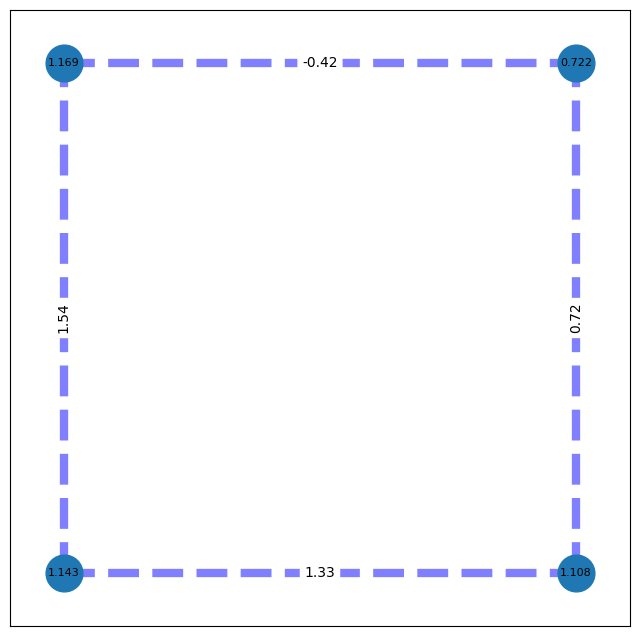

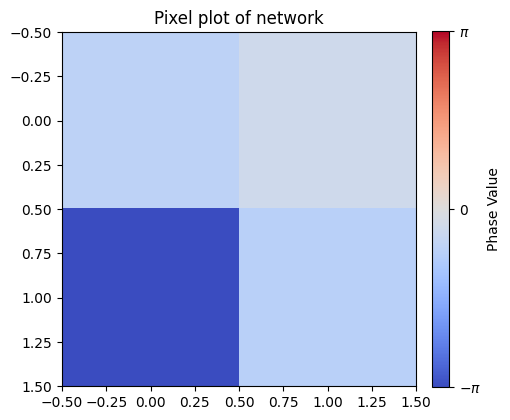

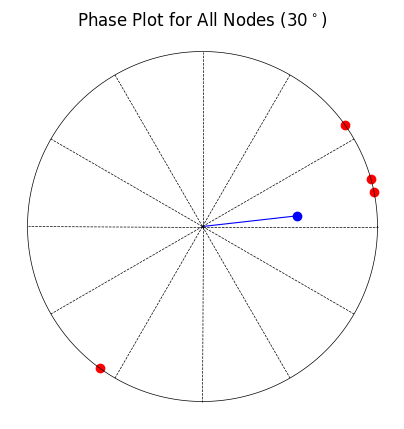

In [3]:
fig = plt.figure(figsize=(8,8))
graph_weighted_plot(G)
plt.show()

pixel_plot, ax = graph_pixel_plot(G, g_len, g_wid)
fig = ax.figure
fig.set_size_inches(5, 5)
plt.show()

fig, ax = draw_phase_correlation(G)
fig = ax.figure
fig.set_size_inches(5, 5)
plt.show()

differential equations and integration

#

In [4]:
def graph_kuramoto_oscillators(theta, t, omega, K, N, coupled_theta):
    """
    Function designed to be integrated with odeint method. Mind that all arrays should be ordered in the same way.

    theta - phase of all oscillators (numpy array of all phases)
    t - time (numpy array)
    omega - angular frequencies of all oscilators (numpy array of all frequencies)
    K - weights of all oscillator couplings (numpy array of numpy arrays of coupling weights)
    N - number of couplings
    coupled_theta - phases of coupled oscillators (numpy array of numpy arrays of coupling phases)
    """
    dtheta_dt = omega - (1/N) * np.sum( K * np.sin(coupled_theta) )
    return dtheta_dt

def integrate_graph(graph, times):
    """
    integrates kuramoto model explicitely using scipy.integrate.odeint method
    """
    theta0 = np.array([n[1] for n in graph.nodes(data="phase")])
    omega = np.array([n[1] for n in graph.nodes(data="frequency")])

    K = [[edge[2] for edge in graph.edges(node, data="weight")] for node in graph.nodes]
    # maybe I should ask Luciano if this N should represent size of network or number of connections
    N = np.array([len(sublist) for sublist in K])
    # padding necessary for numpy methods to work
    max_length = max([len(sublist) for sublist in K])
    K = np.array([sublist + [np.nan]*(max_length - len(sublist)) for sublist in K])
    
    coupled_theta = [[G.nodes[neighbor]['phase'] for neighbor in G.neighbors(n)] for n in G.nodes()]
    max_length = max([len(sublist) for sublist in coupled_theta])
    coupled_theta = np.array([sublist + [np.nan]*(max_length - len(sublist)) for sublist in coupled_theta])

    thetas = odeint(graph_kuramoto_oscillators, theta0, times, args=(omega, K, N, coupled_theta))

    return thetas


In [5]:
T = 10.0  # Total time
dt = 0.01  # Time step
times = np.arange(0, T+dt, dt)
thetas = integrate_graph(G,times)


[18.80353277  9.69353277 13.12353277  8.23353277]
[6.56, -2.2, 0.62, 0.2]
[18.803532766029168, 9.693532766029172, 13.12353276602917, 8.233532766029171]


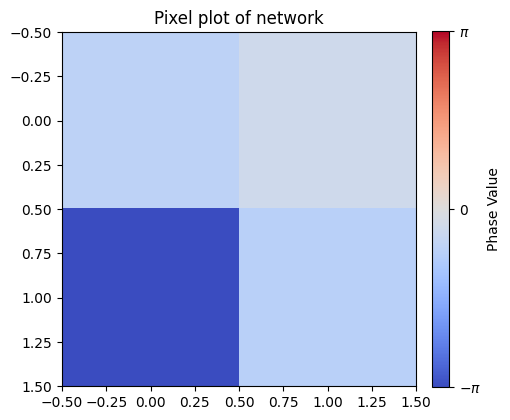

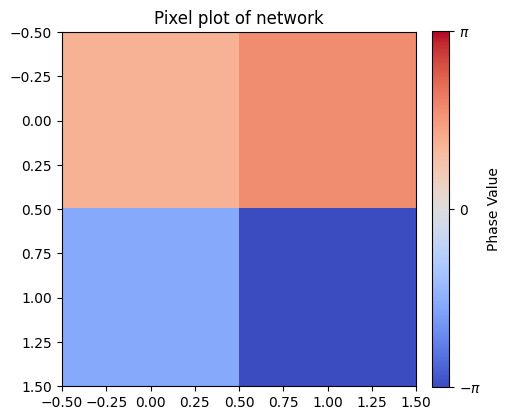

In [6]:
print(thetas[-1])
print([n[1] for n in G.nodes(data="phase")])

def update_graph_nodes(graph, phase_list):
    new_graph = graph.copy()
    phase_dict = {node: phase for node, phase in zip(G.nodes, phase_list)}
    nx.set_node_attributes(new_graph,phase_dict,"phase")
    return new_graph

new_G = update_graph_nodes(G,thetas[-1])

print([n[1] for n in new_G.nodes(data="phase")])

pixel_plot, ax = graph_pixel_plot(G, g_len, g_wid)
fig = ax.figure
fig.set_size_inches(5, 5)
plt.show()

pixel_plot, ax = graph_pixel_plot(new_G, g_len, g_wid)
fig = ax.figure
fig.set_size_inches(5, 5)
plt.show()

plotting result

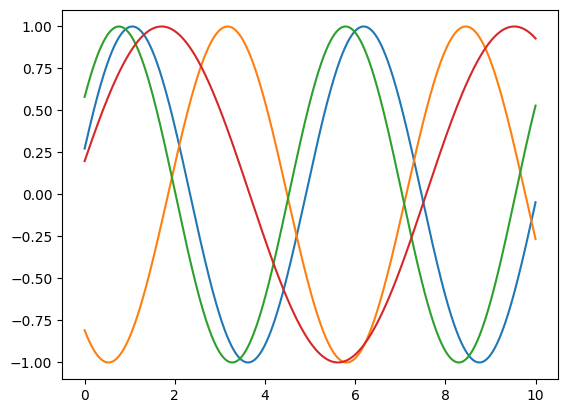

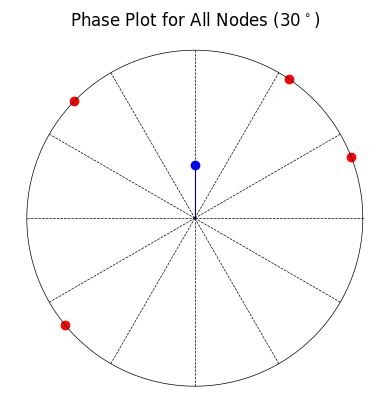

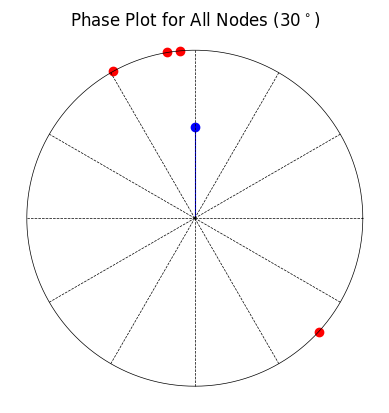

In [7]:
plt.plot(times,np.sin(thetas))
plt.show()


fig, ax = draw_phase_correlation(update_graph_nodes(G,thetas[-1]),True)
plt.show()

fig, ax = draw_phase_correlation(G,True)
plt.show()

# Lorentz attractor
*for odeint reference*

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

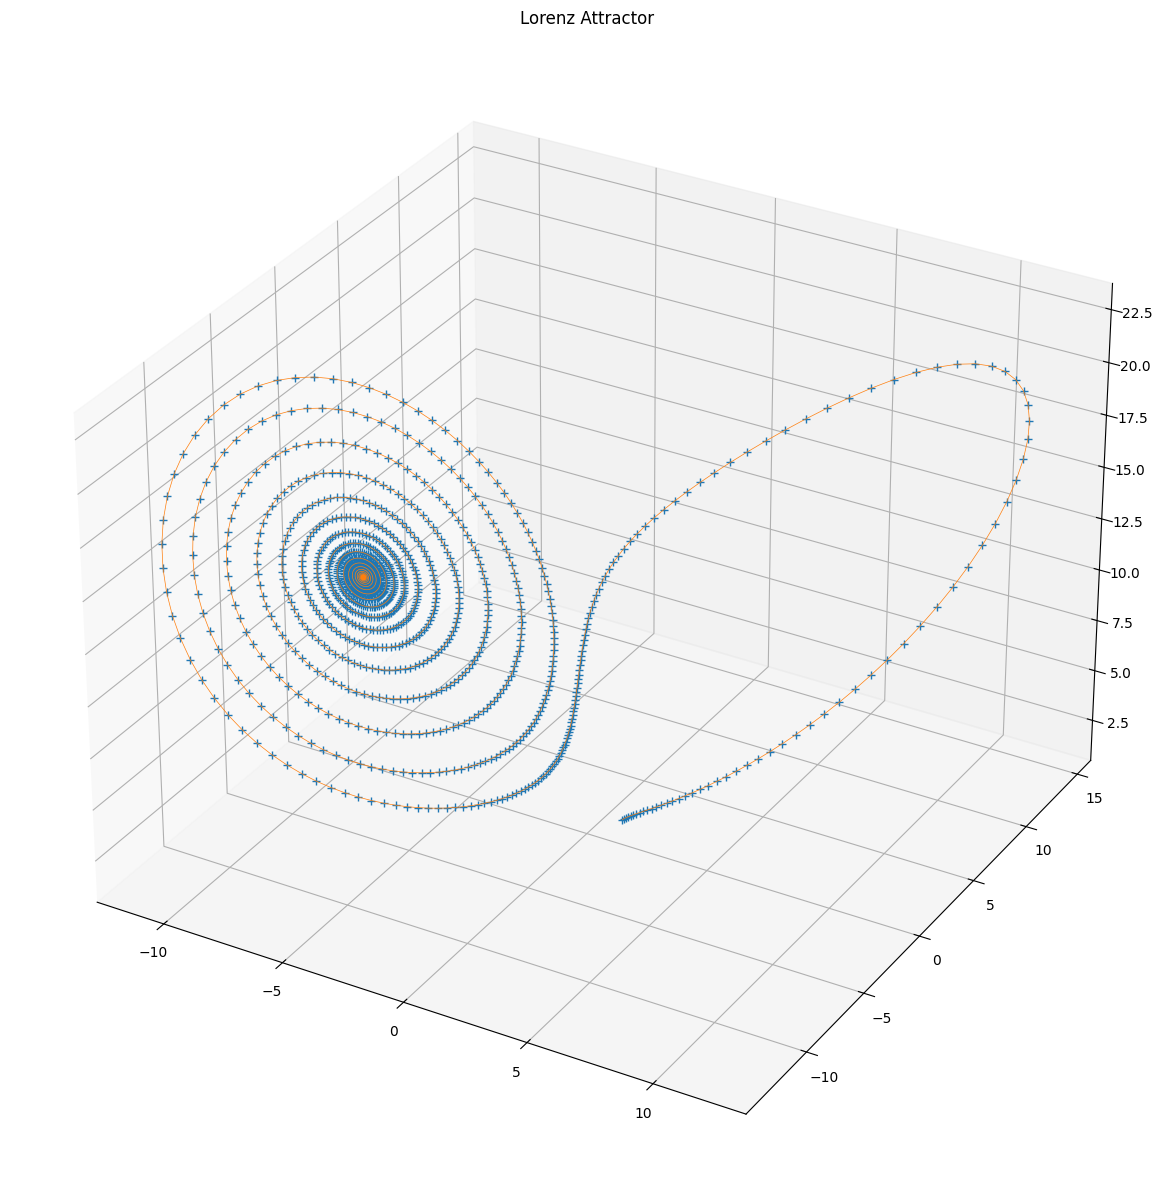

In [ ]:

# for odeint time is the second parameter
def x_eq(x, t, sigma, y):
    dx_dt = sigma*y - sigma*x
    return dx_dt
def y_eq(y, t, r, x, z):
    dy_dt = -x*z+r*x-y
    return dy_dt
def z_eq(z, t, b, x, y):
    dz_dt = x*y-b*z
    return dz_dt

#vector defined set of equations:
def f(state, t):
    x, y, z = state
    df_dt = (x_eq(x,t,sigma,y), 
        y_eq(y,t,r,x,z), 
        z_eq(z, t, b, x, y)) #tuple
    return df_dt

r=15.
sigma=10.
b=8./3.

state0 = [[1.,1.,1.],
    [1.,1.,1.+1e-6]]
t = np.arange(0.,100.,0.01)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection = '3d')

plt.title('Lorenz Attractor')

for idx,xyz in enumerate(state0):
    states = odeint(f, xyz, t)
    markers = ['+','-','x']
    ax.plot(states[:,0], states[:,1], states[:,2],markers[idx],lw=0.5)

plt.show()


# Drawing reference

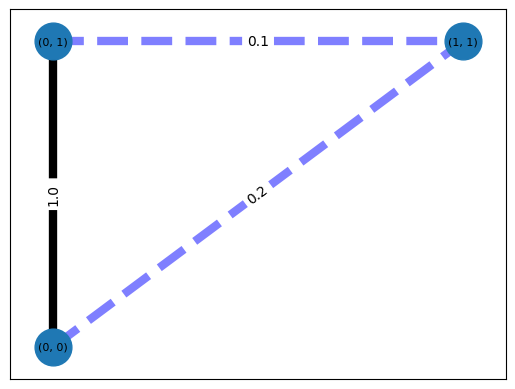

In [ ]:
graph = nx.Graph()
weighted_edges_list = [
    ((0, 0), (0, 1), {'weight': 1.0}),
    ((0, 0), (1, 1), {'weight': 0.2}),
    ((0, 1), (1, 1), {'weight': 0.1})
]
graph.add_edges_from(weighted_edges_list)

graph.add_weighted_edges_from

elarge = [(u, v) for (u, v, d) in graph.edges(data=True) if d["weight"] > 0.5]
esmall = [(u, v) for (u, v, d) in graph.edges(data=True) if d["weight"] <= 0.5]

pos = dict((n, n) for n in G.nodes())
#nodes
nx.draw_networkx_nodes(graph, pos, node_size=700)

#edges
nx.draw_networkx_edges(graph, pos, edgelist=elarge, width=6)
nx.draw_networkx_edges(
    graph, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
)

#edge labels
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph, pos, edge_labels)

#node labels
nx.draw_networkx_labels(graph, pos, font_size=8, font_family="sans-serif")
plt.show()